#### Audio Classification Data Preprocessing

In [36]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Flatten, Dense
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

LABEL_ENCODER = LabelEncoder()

In [37]:
audio_file_path = 'dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/3acc7440-4479-11e9-a9a5-5dbec3b8816a.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [38]:
print(librosa_audio_data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.0792456e-05 7.0427333e-05
 0.0000000e+00]


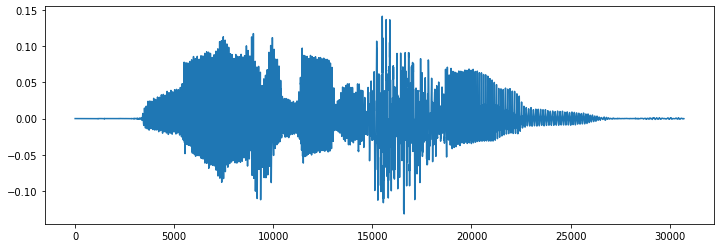

In [39]:
### Lets plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

#### Observation
Here Librosa converts the signal to mono, meaning the channel will alays be 1

In [40]:
### Lets read with scipy
wave_sample_rate, wave_audio = wav.read(audio_file_path)  #%% md
#### Audio Classification Data Preprocessing

In [41]:
### Let's read a sample audio using librosa
audio_file_path = 'dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/3acc7440-4479-11e9-a9a5-5dbec3b8816a.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [42]:
print(librosa_audio_data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.0792456e-05 7.0427333e-05
 0.0000000e+00]


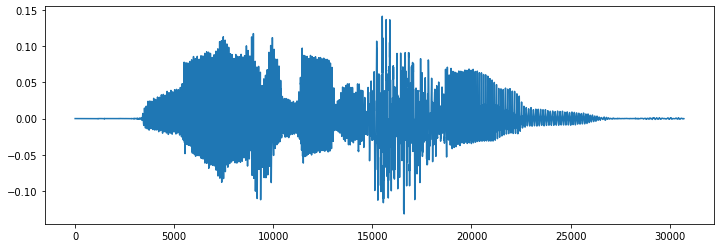

In [43]:
### Lets plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

#### Observation
Here Librosa converts the signal to mono, meaning the channel will alays be 1

In [44]:
### Lets read with scipy
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [45]:
wave_audio

array([0, 0, 0, ..., 2, 2, 2], dtype=int16)

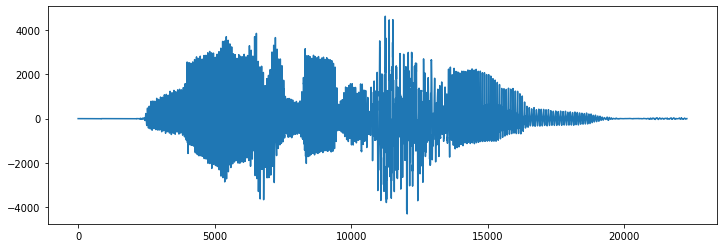

In [46]:
# Original audio with 2 channels
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

### Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio
samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [47]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 61)


In [49]:
mfccs

array([[-7.4111920e+02, -7.3793085e+02, -7.3372919e+02, ...,
        -6.9023126e+02, -6.9762494e+02, -7.0923523e+02],
       [ 2.4239032e+00,  6.8581419e+00,  1.2462606e+01, ...,
         6.7299309e+01,  5.9293739e+01,  4.5494789e+01],
       [ 2.4126921e+00,  6.6367674e+00,  1.1383302e+01, ...,
         5.1713745e+01,  4.8966675e+01,  3.9999344e+01],
       ...,
       [ 6.8582594e-05, -5.7721716e-01, -1.0462627e+00, ...,
        -9.3867071e-02,  1.1653264e+00, -9.1525936e-01],
       [-3.5943024e-02, -5.5208266e-01, -1.3430347e+00, ...,
        -3.0128503e-01,  2.2019703e+00, -3.5509074e-01],
       [-6.7360789e-02, -5.4289007e-01, -1.7864796e+00, ...,
        -6.5210921e-01,  1.7860074e+00, -3.3926344e-01]], dtype=float32)

In [52]:
melspectrogram = librosa.feature.melspectrogram(y=librosa_audio_data, sr=librosa_sample_rate, n_mels=128, fmax=8000)
print(melspectrogram.shape)

(128, 61)


In [53]:
melspectrogram

array([[1.0221391e-06, 2.5539582e-06, 3.6618874e-06, ..., 5.7139737e-06,
        9.2033797e-06, 9.3223089e-06],
       [9.8326518e-07, 4.2117449e-06, 1.3717413e-05, ..., 8.0067526e-05,
        8.4176711e-05, 2.0536820e-05],
       [8.0082214e-07, 4.1976505e-06, 2.1964148e-05, ..., 1.8297965e-04,
        1.3760786e-04, 3.0035006e-05],
       ...,
       [3.8063674e-10, 1.4444147e-09, 3.7924108e-09, ..., 6.4010410e-09,
        4.4015507e-09, 3.4318466e-09],
       [1.0439288e-11, 5.6980566e-11, 2.3711758e-10, ..., 5.1553889e-10,
        6.3354771e-10, 3.9536499e-10],
       [6.0599725e-14, 4.1958291e-13, 6.1142752e-13, ..., 2.1662633e-12,
        4.9767346e-11, 1.8454646e-10]], dtype=float32)

## Dataframe analysis

In [25]:
#### Extracting MFCC's For every audio file
audio_dataset_path = 'dsl_data/audio'
metadata = pd.read_csv('development.csv')

metadata.drop('Id', axis=1, inplace=True)
#TODO REMOVE ME
# metadata = metadata.sample(frac=0.01, random_state=42)

print(len(metadata))
metadata.head(100)

9854


,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...
95,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/c4808...,2BqVo8kVB2Skwgyb,increase,heat,advanced,English (United States),English (United States),female,22-40
96,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/2d859...,2BqVo8kVB2Skwgyb,decrease,heat,advanced,English (United States),English (United States),female,22-40
97,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/32ff8...,2BqVo8kVB2Skwgyb,decrease,heat,advanced,English (United States),English (United States),female,22-40
98,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/34e73...,2BqVo8kVB2Skwgyb,decrease,heat,advanced,English (United States),English (United States),female,22-40


In [27]:
eval_df = pd.read_csv('evaluation.csv')

df_unique_data = get_unique_data(eval_df, 5)
df_unique_data

Self-reported fluency level                               [native]
First Language spoken                    [English (United States)]
Current language used for work/school    [English (United States)]
gender                                              [male, female]
ageRange                                            [22-40, 41-65]
dtype: object

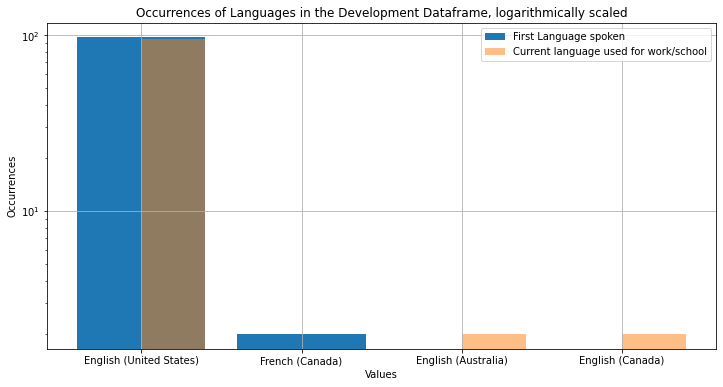

In [29]:
col1_counts = dev_df['First Language spoken'].value_counts()

# Count the occurrences of each value in the second column
col2_counts = dev_df['Current language used for work/school'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(col1_counts.index, col1_counts.values, label='First Language spoken')
ax.bar(col2_counts.index, col2_counts.values, label='Current language used for work/school', width=0.4, align='edge',
       alpha=0.5)

# Add a legend and display the chart
ax.legend()
ax.set_yscale('log')  # this line add the y-axis scaling to logarithmic
plt.xlabel("Values")
plt.grid()
plt.ylabel("Occurrences")
plt.title("Occurrences of Languages in the Development Dataframe, logarithmically scaled")
plt.show()

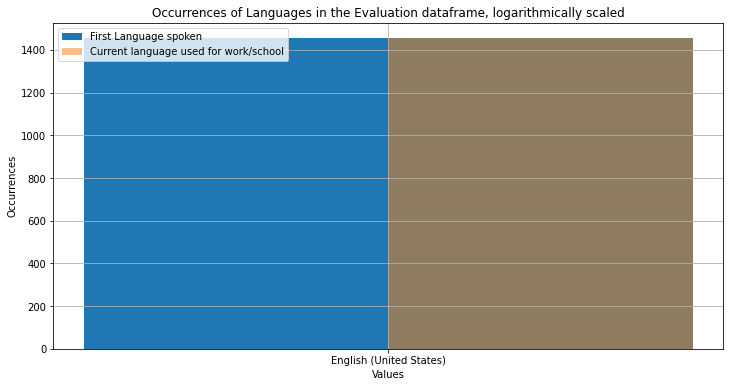

In [31]:
col1_counts = eval_df['First Language spoken'].value_counts()

# Count the occurrences of each value in the second column
col2_counts = eval_df['Current language used for work/school'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(col1_counts.index, col1_counts.values, label='First Language spoken')
ax.bar(col2_counts.index, col2_counts.values, label='Current language used for work/school', width=0.4, align='edge',
       alpha=0.5)

# Add a legend and display the chart
ax.legend()
plt.xlabel("Values")
plt.grid()
plt.ylabel("Occurrences")
plt.title("Occurrences of Languages in the Evaluation dataframe, logarithmically scaled")
plt.show()

In [33]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 8353 to 8917
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   path                                   99 non-null     object
 1   speakerId                              99 non-null     object
 2   action                                 99 non-null     object
 3   object                                 99 non-null     object
 4   Fluency                                99 non-null     object
 5   First Language spoken                  99 non-null     object
 6   Current language used for work/school  99 non-null     object
 7   gender                                 99 non-null     object
 8   ageRange                               99 non-null     object
dtypes: object(9)
memory usage: 7.7+ KB


### Dataframe cleaning after analyisys

In [540]:
metadata.drop(metadata[metadata['First Language spoken'] != 'English (United States)'].index, inplace=True)
metadata.drop(metadata[metadata['Current language used for work/school'] != 'English (United States)'].index,
              inplace=True)
print(len(metadata))

9577


In [34]:
metadata.drop('First Language spoken', axis=1, inplace=True)
metadata.drop('Current language used for work/school', axis=1, inplace=True)
print(len(metadata))

9854


In [542]:
mapping = {metadata.columns[4]: 'Fluency', }
metadata = metadata.rename(columns=mapping)

### Utility functions

In [543]:
def mfccs_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    audio, _ = librosa.effects.trim(audio)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=140)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [544]:
def spectogram_extractor(file):
    y, sr = librosa.load(file)
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    melspectrogram_scaled_features = np.mean(melspectrogram.T, axis=0)
    return melspectrogram_scaled_features

In [545]:
def create_sentence(row):
    return row["action"] + row["object"]

In [546]:
def ohe_and_append(target_df, column):
    one_hot = pd.get_dummies(target_df[column])
    target_df = target_df.join(one_hot)
    target_df.drop(column, axis=1, inplace=True)
    return target_df

### Rearranging the dataframe

In [547]:
from sklearn.preprocessing import OneHotEncoder

fluency_encoder = OneHotEncoder()


def rearrange_dataframe(reg_df, evaluation=False):
    tqdm.pandas(ncols=50)
    reg_df["mfccs_scaled_features"] = reg_df['path'].progress_apply(lambda path: mfccs_extractor(path))
    reg_df["spectogram_features"] = reg_df['path'].progress_apply(lambda path: spectogram_extractor(path))

    one_hot = pd.get_dummies(reg_df['gender'])
    reg_df = reg_df.join(one_hot)
    reg_df.drop('gender', axis=1, inplace=True)

    # one_hot = pd.get_dummies(reg_df['speakerId'])
    # reg_df = reg_df.join(one_hot)
    reg_df.drop('speakerId', axis=1, inplace=True)

    # encoded_column = fluency_encoder.fit_transform(reg_df[['Fluency']])
    # encoded_column_names = fluency_encoder.get_feature_names_out(['Fluency'])
    # reg_df = pd.concat([reg_df, pd.DataFrame(encoded_column.toarray(), columns=encoded_column_names)], axis=1)
    reg_df.drop('Fluency', axis=1, inplace=True)

    another_encoder = LabelEncoder()
    reg_df['ageRange'] = another_encoder.fit_transform(reg_df['ageRange'])
    reg_df = reg_df.reindex(sorted(reg_df.columns), axis=1)

    reg_df.drop('path', axis=1, inplace=True)
    if not evaluation:
        reg_df["sentence"] = reg_df.progress_apply(create_sentence, axis=1)
        reg_df.drop('action', axis=1, inplace=True)
        reg_df.drop('object', axis=1, inplace=True)
    return reg_df.copy()

In [548]:
# mapping = {metadata.columns[4]: 'Fluency', }
# metadata = metadata.rename(columns=mapping)
# metadata.head()

In [549]:
# tqdm.pandas(ncols=50)
# metadata["mfccs_scaled_features"] = metadata['path'].progress_apply(lambda path: mfccs_extractor(path))

In [550]:
# metadata["spectogram_features"] = metadata['path'].progress_apply(lambda path: spectogram_extractor(path))

In [551]:
# metadata["sentence"] = metadata.progress_apply(create_sentence, axis=1)
# w_metadata = metadata.copy()
# w_metadata.drop('path', axis=1, inplace=True)
# w_metadata.drop('action', axis=1, inplace=True)
# w_metadata.drop('object', axis=1, inplace=True)
# w_metadata

In [552]:
# one_hot = pd.get_dummies(w_metadata['gender'])
# w_metadata = w_metadata.join(one_hot)
# w_metadata.drop('gender', axis=1, inplace=True)
#
# one_hot = pd.get_dummies(w_metadata['speakerId'])
# w_metadata = w_metadata.join(one_hot)
# w_metadata.drop('speakerId', axis=1, inplace=True)
#
# one_hot = pd.get_dummies(w_metadata['Fluency'])
# w_metadata = w_metadata.join(one_hot)
# w_metadata.drop('Fluency', axis=1, inplace=True)
#
#
# # w_metadata = ohe_and_append(w_metadata, 'speakerId')
# # w_metadata = ohe_and_append(w_metadata, 'Fluency')
# # # w_metadata['First Language spoken'] = LABEL_ENCODER.fit_transform(metadata['First Language spoken'])
# # # w_metadata['Current language used for work/school'] = LABEL_ENCODER.fit_transform(metadata['Current language used for work/school'])
#
# another_encoder = LabelEncoder()
# w_metadata['ageRange'] = another_encoder.fit_transform(metadata['ageRange'])
# w_metadata = w_metadata.reindex(sorted(w_metadata.columns), axis=1)
# w_metadata

In [553]:
w_metadata = rearrange_dataframe(metadata)
w_metadata

100%|█████| 9577/9577 [00:00<00:00, 123532.22it/s]


,ageRange,female,male,mfccs_scaled_features,spectogram_features,sentence
0,0,1,0,"[-511.07755, 58.566845, -31.1752, 60.42457, -3...","[7.0757036e-05, 0.00016309676, 0.00065370527, ...",change languagenone
1,0,1,0,"[-591.3221, 85.18859, 4.8237906, 36.32537, -7....","[6.604454e-05, 8.7514054e-05, 0.00010744974, 0...",activatemusic
2,0,1,0,"[-633.9742, 120.09, -8.356079, 12.418757, 1.23...","[3.745495e-05, 0.0001055681, 0.00042638168, 0....",deactivatelights
3,0,1,0,"[-453.0278, 128.96875, -33.29996, 21.595337, -...","[0.007695751, 0.07239886, 0.2848914, 0.8059597...",increasevolume
4,0,1,0,"[-668.1929, 114.65774, 10.636849, -2.3549967, ...","[0.002472366, 0.032411344, 0.098514386, 0.1049...",increasevolume
...,...,...,...,...,...,...
9849,0,0,1,"[-464.1819, 87.841545, -8.056641, 26.83193, -4...","[0.17780903, 0.010965303, 0.016069291, 0.12706...",decreasevolume
9850,0,0,1,"[-468.26077, 66.74261, -15.260388, 32.130295, ...","[0.17176418, 0.005633395, 0.008156301, 0.11034...",deactivatelights
9851,0,0,1,"[-435.99023, 83.720314, -22.195066, 26.548294,...","[0.18851712, 0.009013464, 0.016889825, 0.03234...",deactivatelights
9852,0,0,1,"[-491.20547, 64.46802, -10.698871, 28.392767, ...","[0.188645, 0.0058759963, 0.0064189406, 0.01714...",deactivatelights


In [554]:
w_metadata_columns = w_metadata.columns.tolist()
print(len(w_metadata_columns))

6


In [555]:
w_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9577 entries, 0 to 9853
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ageRange               9577 non-null   int32 
 1   female                 9577 non-null   uint8 
 2   male                   9577 non-null   uint8 
 3   mfccs_scaled_features  9577 non-null   object
 4   spectogram_features    9577 non-null   object
 5   sentence               9577 non-null   object
dtypes: int32(1), object(3), uint8(2)
memory usage: 613.4+ KB


In [556]:
### Split the dataset into independent and dependent dataset
np_mfccs_scaled = np.array(w_metadata['mfccs_scaled_features'].tolist())
np_spectogram = np.array(w_metadata['spectogram_features'].tolist())
w_metadata.drop('mfccs_scaled_features', axis=1, inplace=True)
w_metadata.drop('spectogram_features', axis=1, inplace=True)

In [557]:
y_7_dim = pd.get_dummies(w_metadata['sentence']).to_numpy()
y_7_dim

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [558]:
sentences_list = np.array(w_metadata['sentence'].tolist())
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

SENTENCE_ENCODER_7 = LabelEncoder()
y_1_dim = SENTENCE_ENCODER_7.fit_transform(sentences_list)

In [559]:
w_metadata.drop('sentence', axis=1, inplace=True)
w_metadata.head()

,ageRange,female,male
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [560]:
np_metadata_converted = w_metadata.to_numpy()
np_metadata_converted.shape

(9577, 3)

In [561]:
np_mfccs_scaled.shape

(9577, 128)

In [562]:
np_spectogram.shape

(9577, 128)

In [563]:
X_main = np.append(np_mfccs_scaled, np_spectogram, axis=1)

In [564]:
X_main.shape

(9577, 256)

In [565]:
X_main = np.append(X_main, np_metadata_converted, axis=1)

In [566]:
X_main.shape

(9577, 259)

In [567]:
y_1_dim.shape

(9577,)

In [568]:
y_7_dim.shape

(9577, 7)

### Eval DF

### Testing Some Test Audio Data

Steps
- Preprocess the new audio data
- predict the classes
- Invere transform your Predicted Label

In [569]:
evaluation_df = pd.read_csv('evaluation.csv')
evaluation_df.drop('Id', axis=1, inplace=True)

#TODO REMOVE ME
# evaluation_df = evaluation_df.sample(frac=0.1, random_state=42)

mapping = {evaluation_df.columns[2]: 'Fluency', }
evaluation_df = evaluation_df.rename(columns=mapping)

evaluation_df.head()

,path,speakerId,Fluency,First Language spoken,Current language used for work/school,gender,ageRange
0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
2,dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d5...,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65
3,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
4,dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a...,V4ZbwLm9G5irobWn,native,English (United States),English (United States),female,41-65


In [570]:
evaluation_df.drop('First Language spoken', axis=1, inplace=True)
evaluation_df.drop('Current language used for work/school', axis=1, inplace=True)

In [571]:
eval_rearranged = rearrange_dataframe(evaluation_df, evaluation=True)

100%|█████████| 1455/1455 [01:09<00:00, 20.90it/s]


In [572]:
# evaluation_df["mfccs_scaled_features"] = evaluation_df['path'].progress_apply(lambda path: mfccs_extractor(path))
# evaluation_df["spectogram_features"] = evaluation_df['path'].progress_apply(lambda path: spectogram_extractor(path))
# evaluation_df.drop('path', axis=1, inplace=True)
#
# evaluation_df= ohe_and_append(evaluation_df, 'speakerId')
# evaluation_df= ohe_and_append(evaluation_df, 'Fluency')
# # evaluation_df['First Language spoken'] = LABEL_ENCODER.fit_transform(evaluation_df['First Language spoken'])
# # evaluation_df['Current language used for work/school'] = LABEL_ENCODER.fit_transform(evaluation_df['Current language used for work/school'])
# evaluation_df = ohe_and_append(evaluation_df, 'gender')
# evaluation_df['ageRange'] = LABEL_ENCODER.fit_transform(evaluation_df['ageRange'])
#
# evaluation_df = evaluation_df.reindex(sorted(evaluation_df.columns), axis=1)
# evaluation_df.head()
eval_np = np.array(eval_rearranged['mfccs_scaled_features'].tolist())
eval_rearranged.drop('mfccs_scaled_features', axis=1, inplace=True)

spect_np = np.array(eval_rearranged['spectogram_features'].tolist())
eval_rearranged.drop('spectogram_features', axis=1, inplace=True)
eval_np = np.append(eval_np, spect_np, axis=1)

evaluation_df_converted = eval_rearranged.to_numpy()

In [573]:
eval_rearranged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ageRange  1455 non-null   int32
 1   female    1455 non-null   uint8
 2   male      1455 non-null   uint8
dtypes: int32(1), uint8(2)
memory usage: 8.7 KB


In [574]:
w_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9577 entries, 0 to 9853
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ageRange  9577 non-null   int32
 1   female    9577 non-null   uint8
 2   male      9577 non-null   uint8
dtypes: int32(1), uint8(2)
memory usage: 389.0 KB


In [575]:
evaluation_df_columns = eval_rearranged.columns.tolist()
print(w_metadata_columns == evaluation_df_columns)
print(str(len(w_metadata_columns)) + " " + str(len(eval_rearranged)))

False
6 1455


In [576]:

eval_np = np.append(eval_np, evaluation_df_converted, axis=1)
eval_np.shape

(1455, 259)

In [577]:
eval_np.shape

(1455, 259)

In [604]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_1_dim, test_size=0.2, random_state=0)

In [579]:
X_train.shape

(7661, 259)

In [580]:
X_test.shape

(1916, 259)

In [605]:
y_train.shape

(7661,)

In [606]:
y_test.shape

(1916,)

In [607]:
y_train

array([6, 4, 3, ..., 6, 6, 5], dtype=int64)

In [583]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  3%|▎         | 1/29 [00:14<06:58, 14.96s/it]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')


  7%|▋         | 2/29 [00:33<07:47, 17.33s/it]

ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')


 14%|█▍        | 4/29 [02:03<14:26, 34.66s/it]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 28%|██▊       | 8/29 [02:06<03:56, 11.27s/it]

ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for ExtraTreeClassifier
multi_class must be in ('ovo', 'ovr')


 34%|███▍      | 10/29 [02:08<02:14,  7.08s/it]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')


 38%|███▊      | 11/29 [02:09<01:35,  5.30s/it]

ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')


 41%|████▏     | 12/29 [02:13<01:24,  5.00s/it]

ROC AUC couldn't be calculated for LabelPropagation
multi_class must be in ('ovo', 'ovr')


 45%|████▍     | 13/29 [02:17<01:17,  4.87s/it]

ROC AUC couldn't be calculated for LabelSpreading
multi_class must be in ('ovo', 'ovr')


 48%|████▊     | 14/29 [02:18<00:54,  3.60s/it]

ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 52%|█████▏    | 15/29 [02:42<02:14,  9.62s/it]

ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')


 62%|██████▏   | 18/29 [02:43<00:42,  3.83s/it]

ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
NuSVC model failed to execute
specified nu is infeasible


 66%|██████▌   | 19/29 [02:43<00:29,  2.98s/it]

ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')


 69%|██████▉   | 20/29 [02:43<00:20,  2.26s/it]

ROC AUC couldn't be calculated for Perceptron
multi_class must be in ('ovo', 'ovr')


 72%|███████▏  | 21/29 [02:44<00:15,  1.91s/it]

ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 79%|███████▉  | 23/29 [02:57<00:20,  3.49s/it]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')


 83%|████████▎ | 24/29 [02:57<00:12,  2.58s/it]

ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')


 86%|████████▌ | 25/29 [02:59<00:09,  2.37s/it]

ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')


 90%|████████▉ | 26/29 [03:07<00:12,  4.08s/it]

ROC AUC couldn't be calculated for SVC
multi_class must be in ('ovo', 'ovr')
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


 97%|█████████▋| 28/29 [03:28<00:06,  6.98s/it]

ROC AUC couldn't be calculated for XGBClassifier
multi_class must be in ('ovo', 'ovr')


100%|██████████| 29/29 [03:31<00:00,  7.30s/it]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.50,0.45,None,0.50,20.83
LGBMClassifier,0.49,0.45,None,0.49,3.18
KNeighborsClassifier,0.41,0.38,None,0.41,0.16
SVC,0.44,0.37,None,0.43,8.17
ExtraTreesClassifier,0.45,0.36,None,0.43,2.47
RandomForestClassifier,0.43,0.35,None,0.41,12.40
BaggingClassifier,0.39,0.35,None,0.39,18.99
LogisticRegression,0.36,0.34,None,0.36,0.45
LinearDiscriminantAnalysis,0.37,0.33,None,0.36,0.39


In [615]:
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.471


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [586]:
predictions = model.predict(eval_np)
array = SENTENCE_ENCODER_7.inverse_transform(predictions)

In [587]:
df = pd.DataFrame(array)
df.to_csv('evaluation2.csv', sep='\t')

### Keras

In [588]:
# print(tf.__version__)

2.11.0


In [589]:
# X_test.shape

(1916, 259)

In [590]:
# kerasencoder = LabelEncoder()
# y_7_dim = to_categorical(kerasencoder.fit_transform(sentences_list))
# num_labels = y_7_dim.shape[1]
# num_labels

7

In [618]:
# X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_main, y_7_dim, test_size=0.2, random_state=0)

In [619]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.optimizers import Adam
# from sklearn import metrics

In [628]:
# model = Sequential()
#
# model.add(Dense(64, input_shape=(X_test_7.shape[1],), kernel_initializer='he_uniform',
#                 kernel_regularizer=None, kernel_constraint='MaxNorm', activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(150))
# model.add(Dense(num_labels, activation='softmax'))
#

In [629]:
# model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                16640     
                                                                 
 dense_25 (Dense)            (None, 100)               6500      
                                                                 
 dense_26 (Dense)            (None, 150)               15150     
                                                                 
 dense_27 (Dense)            (None, 7)                 1057      
                                                                 
Total params: 39,347
Trainable params: 39,347
Non-trainable params: 0
_________________________________________________________________


In [630]:
# model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')

In [631]:
# ## Trianing my model
# from keras.callbacks import ModelCheckpoint
# from datetime import datetime
#
# num_epochs = 70
# num_batch_size = 32
#
# checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',
#                                verbose=1, save_best_only=True)
# start = datetime.now()
#
# model.fit(X_train_7, y_train_7, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test_7, y_test_7),
#           callbacks=[checkpointer], verbose=1)
#
# duration = datetime.now() - start
# print("Training completed in time: ", duration)
#
# test_accuracy = model.evaluate(X_test_7, y_test_7, verbose=0)
# print(test_accuracy[1])

Epoch 1/70
222/240 [==========================>...] - ETA: 0s - loss: 0.2520 - accuracy: 0.1173
Epoch 1: val_loss improved from inf to 0.25142, saving model to saved_models\audio_classification.hdf5
240/240 [==============================] - 1s 2ms/step - loss: 0.2519 - accuracy: 0.1179 - val_loss: 0.2514 - val_accuracy: 0.1200
Epoch 2/70
205/240 [========================>.....] - ETA: 0s - loss: 0.2510 - accuracy: 0.1216
Epoch 2: val_loss did not improve from 0.25142
240/240 [==============================] - 0s 1ms/step - loss: 0.2513 - accuracy: 0.1206 - val_loss: 0.2514 - val_accuracy: 0.1200
Epoch 3/70
220/240 [==========================>...] - ETA: 0s - loss: 0.2515 - accuracy: 0.1197
Epoch 3: val_loss did not improve from 0.25142
240/240 [==============================] - 0s 1ms/step - loss: 0.2513 - accuracy: 0.1206 - val_loss: 0.2514 - val_accuracy: 0.1200
Epoch 4/70
218/240 [==========================>...] - ETA: 0s - loss: 0.2511 - accuracy: 0.1210
Epoch 4: val_loss did not 

In [624]:
# # Make predictions on the new data
# predictions = model.predict(eval_np)
# array = SENTENCE_ENCODER_7.inverse_transform(np.argmax(predictions, axis=1))
# # Print the predictions
# print(array)

46/46 [==============================] - 0s 645us/step
['increasevolume' 'increasevolume' 'increasevolume' ... 'increasevolume'
 'increasevolume' 'increasevolume']


In [625]:
# df = pd.DataFrame(array)
# df.to_csv('evaluation_keras.csv', sep='\t')

In [626]:
# import os
# from keras.applications.vgg19 import VGG19
# from keras.preprocessing import image
# from keras.applications.vgg19 import preprocess_input
# from keras.models import Model
# import numpy as np
#
# base_model = VGG19(weights='imagenet')
# model2 = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)
#
# from sklearn.model_selection import train_test_split
# from sklearn.svm import LinearSVC
# from sklearn.metrics import accuracy_score
#
# X_train, X_test, y_train, y_test = train_test_split(X_main, y_1_dim, test_size=0.30, random_state=42, stratify=y_1_dim)
#
# clf = LinearSVC(random_state=0, tol=1e-5)
# clf.fit(X_train, y_train)
#
# predicted = clf.predict(X_test)
#
# # get the accuracy
# print(accuracy_score(y_test, predicted))

0.2849686847599165
